Student Name: **Siddharth Prince**

Student ID: **23052058**

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np

torch.manual_seed(42)

### Utility code
Utility functions that I've written for repetitive stuff like plotting graphs, etc.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot. 
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005
        
        plt.plot(X, y, label=label, marker=marker)
        
        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [3]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [41]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it
        
        optimizer.zero_grad()               #<--- what is this for?
        
        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

While I was just looking at the train method, I got confused as to where the features and labels are passed to the train step and where the split is done. Then I looked at the entire code and saw that there is a separate train and test dataloader object. So, that made sense.  

1. ***model.train()***
   - This seems weird at first because from what we've seen in prior activities with the sklearn model classes, we'd call a 'fit' method while passing the features and labels to it. But after looking at the [Pytorch docs](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train), this method is called to set the model into training mode. From what I understand, this dictates the behviour of the class when certain functions/modules such as 'BatchNorm' are called.
   - The [eval() method call](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) in the test method from the above code does the opposite of this and sets the model class in evaluation mode. This is equivalent to calling model.train(mode=False).  
2. ***X, y = X.to(device), y.to(device)***  
   - Since pytorch creates tensors in memory accessible to whatever default device i.e, CPU or GPU being used, this line is to ensure that we move the tensors to whichever device memory we have defined in the 'device' variable.
   - Here it is CUDA since I have a CUDA capable Nvidia GPU as seen in the output from code cell #3.
   - Also, the code unpacks the enumerated batches (index numbers) and corresponding featurelabel data tuple pairs as X, y separately which are torch tensors. The to() method is part of the torch.Tensor class which defines all aspects of the "Tensor" data type.
3. ***pred = model(X)***  
   The Tensor object that holds the features on which the model is to be trained is passed to an instance of the defined model class which returns the class predictions after being processed by the nn model. Similar in functionality to the 'model.predict(X_test)' that's common with Scikit-Learn's model classes. Except, here the predictions are for the training data.
4. ***loss = loss_fn(pred, y)***  
   The loss function passed as a parameter is declared in subsequent code cells (Cross Entropy Loss function is used). This method call takes the predicted output and the actual output and returns the difference according to the loss function specified. Minimising the loss is the goal for our neural network.
5. ***loss.backward()***  
   The backward function call computes the gradient of the tensor w.r.t the current weights. Using the gradient, we can optimise the model by moving in its direction by updating the model weights.
6. ***optimizer.step()***  
    This line calls the step function which updates the weights in the network based on the gradients computed in the previous step by the backward function call. This is similar to how it was implemented in the train function of the Adaline class implementation from a couple of activities back. Of course, how the weights get updated depend on the optimiser being used for training.
7. ***optimizer.zero_grad()***
   The pytorch function zero_grad() here ensures that the gradients for a model, accumulated by pytorch on backward passes, are cleared. From what I've read about this, the accumulation is convenient for training RNNs. If not, they need to be cleared or current gradient will be a combination of the old gradient and the newly computed gradient. [StackOverflow reference](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch). Also, here they tell us to clear the gradients before computing the loss which makes sense because the very first iteration of a training loop will get affected by prior gradients otherwise. Hence, I moved this line of code above the call to the loss function.

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [5]:
##############################
# Your code below
# Defining the transform to passed when loading data
transform = transforms.Compose([transforms.Resize((28, 28)), 
                               transforms.ToTensor(),
                               transforms.Normalize(mean=0.2859, std=0.3530)
                               ])

# Loading the Fashion-MNIST dataset
fMnist_train = datasets.FashionMNIST('./datasets/', download=True, train=True, transform=transform)
fMnist_test = datasets.FashionMNIST('./datasets/', download=True, train=False, transform=transform)

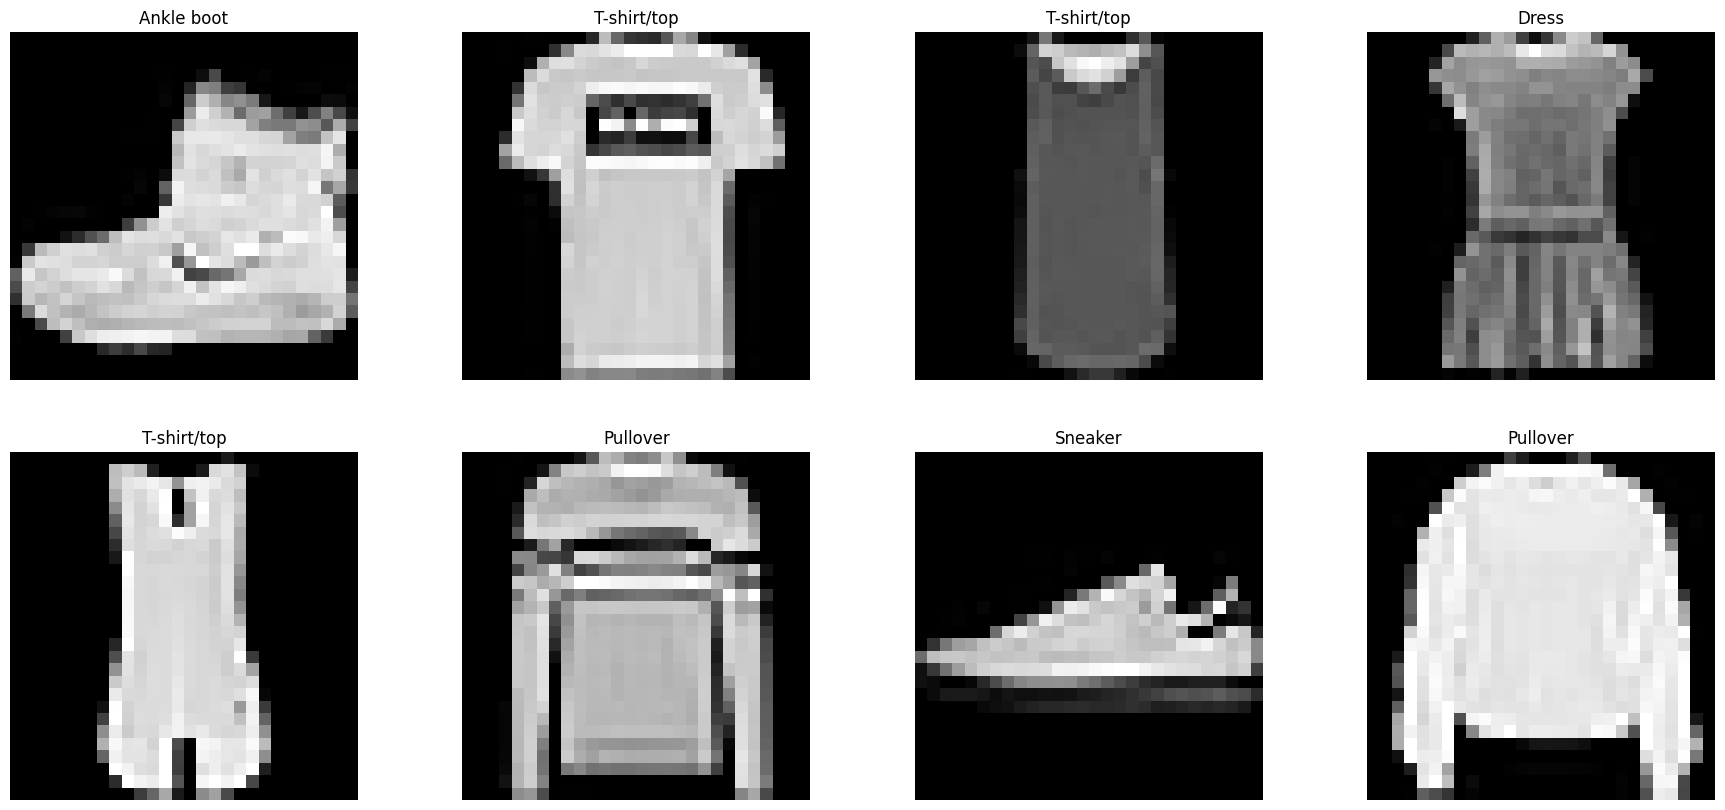

In [6]:
# Creating DataLoaders
train_dataloader = torch.utils.data.DataLoader(fMnist_train, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(fMnist_test, batch_size=64, shuffle=True)

# Displaying a few examples of he dataset to ensure they have been loaded correctly.
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.subplots_adjust(wspace=0.3)
ax = ax.flatten()
text_labels = {v: k for k, v in fMnist_train.class_to_idx.items()}
for i in range(8):
    ax[i].imshow(fMnist_train[i][0].reshape((28, 28)), cmap='gray')
    ax[i].axis('off')  # clear x-axis and y-axis
    ax[i].set_title(text_labels[fMnist_train[i][1]])

plt.show()


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [7]:
##############################
# Your code below

# Define model
class NeuralNetworkPrev(nn.Module):
    def __init__(self):
        super(NeuralNetworkPrev, self).__init__()
        self.input = nn.Linear(784, 100)
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        # using the ReLU activation function here as the default activation function used in Scikit-learn's MLPClassifier is ReLU.
        x = F.relu(self.input(x)) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

modelPrev = NeuralNetworkPrev().to(device=device)

print(modelPrev)
summary(modelPrev, (1,28*28))

NeuralNetworkPrev(
  (input): Linear(in_features=784, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                   [-1, 50]           5,050
            Linear-4                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [8]:
# Testing with random inputs
input_tensor = torch.randn(64, 28*28)
output_tensor = modelPrev(input_tensor.cuda())
print(output_tensor)

tensor([[ 2.2303e-01, -1.1104e-01, -8.5901e-02, -4.1224e-02, -1.8770e-02,
          5.8422e-02,  3.5470e-02, -8.8084e-02, -9.6660e-02,  1.7170e-02],
        [ 2.4467e-01, -7.6552e-02, -7.6085e-02,  2.8800e-03, -4.6388e-02,
          8.8689e-02,  5.9019e-02, -5.3810e-02, -1.6731e-01,  3.9450e-02],
        [ 2.5248e-01, -5.8637e-02, -6.7770e-02, -4.6614e-03,  8.9025e-03,
          9.9861e-02,  2.9095e-02, -6.9649e-02, -1.5018e-01,  3.5279e-02],
        [ 1.9993e-01, -7.3841e-02, -9.1240e-02, -9.4626e-03, -2.8211e-02,
          4.4192e-02,  5.7036e-02, -3.3032e-02, -1.7005e-01,  3.1145e-02],
        [ 2.9279e-01, -8.8838e-02, -5.6693e-02,  7.9511e-03, -3.2031e-02,
          3.9669e-02,  5.5074e-02, -4.8436e-02, -1.6435e-01,  2.4179e-02],
        [ 2.3880e-01, -7.7818e-02, -1.4596e-02,  3.1653e-02, -2.2274e-02,
          5.0268e-02,  1.3471e-02, -9.9379e-02, -2.1398e-01,  3.5441e-02],
        [ 2.1714e-01, -1.0181e-01, -3.9472e-02, -3.9377e-02, -5.6380e-02,
          1.1558e-01,  9.6425e-0

Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [9]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelPrev.parameters(), lr=1e-3)

##############################
# Your code below
epochs = 10
train_loss_prev, train_accuracy_prev, test_loss_prev, test_accuracy_prev = train_loop(train_dataloader, test_dataloader, modelPrev, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.319669  [   64/60000]
loss: 0.777084  [ 6464/60000]
loss: 0.390960  [12864/60000]
loss: 0.582642  [19264/60000]
loss: 0.423866  [25664/60000]
loss: 0.426950  [32064/60000]
loss: 0.371486  [38464/60000]
loss: 0.648673  [44864/60000]
loss: 0.342473  [51264/60000]
loss: 0.459239  [57664/60000]
Train Error: 
 Accuracy: 86.4%, Avg loss: 0.371131 

Test Error: 
 Accuracy: 84.9%, Avg loss: 0.419851 

Epoch 2:

loss: 0.523232  [   64/60000]
loss: 0.353434  [ 6464/60000]
loss: 0.418702  [12864/60000]
loss: 0.277380  [19264/60000]
loss: 0.193542  [25664/60000]
loss: 0.380308  [32064/60000]
loss: 0.400964  [38464/60000]
loss: 0.296106  [44864/60000]
loss: 0.250443  [51264/60000]
loss: 0.359546  [57664/60000]
Train Error: 
 Accuracy: 87.5%, Avg loss: 0.334201 

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.390456 

Epoch 3:

loss: 0.329438  [   64/60000]
loss: 0.239624  [ 6464/60000]
loss: 0.219851  [12864/60000]
loss: 0.235623  [19264/60000]
loss: 0.230381  [25664/60000]
loss: 0.32

#### Plotting train and test loss metrics

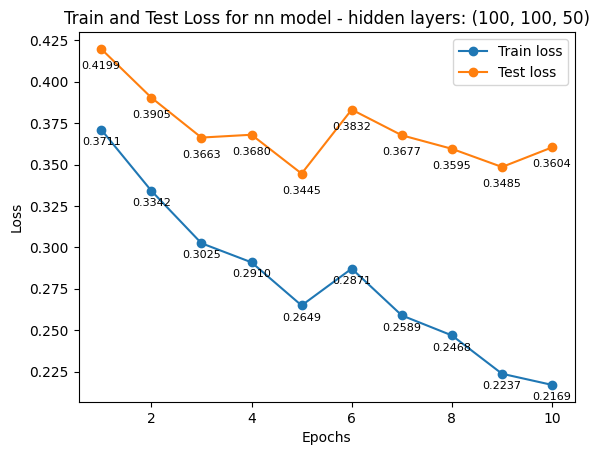

In [48]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_prev, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.009}), 
                (test_loss_prev, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for nn model - hidden layers: (100, 100, 50)'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

#### Plotting train and test accuracy metrics

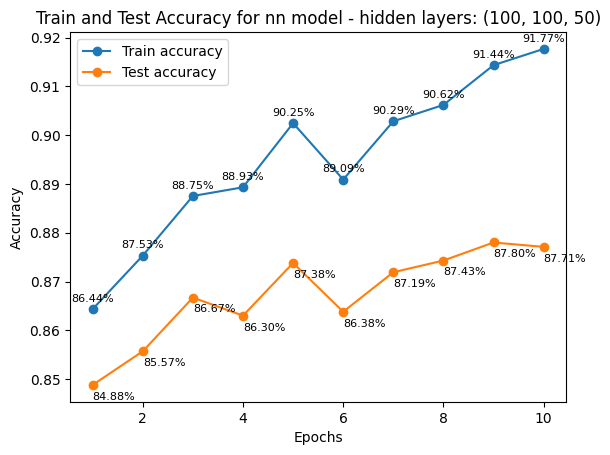

In [45]:
# Defining data and plot params
epochs = 10
epochRange = range(1, epochs+1)
accuracyDataList = [(train_accuracy_prev, {'label': 'Train accuracy', 'displayOffset': 0.0015,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_prev, {'label': 'Test accuracy', 'ha': 'left', 'displayOffset': -0.003,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for nn model - hidden layers: (100, 100, 50)'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Observations
Between epochs 5 and 6, the model seems to have overshot the minima of the loss because we can see corresponding dips in both training and testing accuracies. Same for the sudden increase in loss values at epoch #6. After this though, it seems to gradually be able to correct its trajectory. However, there are slight signs of overfitting between epochs 3, 4 and epochs 9, 10. In both these instances, though the metrics for training have improved, there is a decline in test accuracy (increase in terms of loss). To compare, the best accuracy I got for the (100, 100, 50) layer architecture from activity 5 was 89.27% accuracy. Hence, this is a slight deterioration.


---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

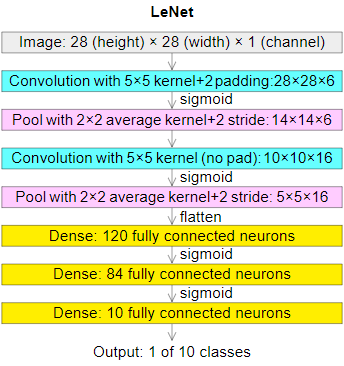

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [12]:
##############################
# Your code below

# Define model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = F.avg_pool2d(x, (2, 2))
        x = F.sigmoid(self.conv2(x))
        x = F.avg_pool2d(x, (2, 2))
        x = torch.flatten(x, 1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

modelLeNet5 = LeNet5().to(device=device)
print(modelLeNet5)
summary(modelLeNet5, (1, 28, 28))

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estim

/home/sprince0031/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [13]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelLeNet5.parameters(), lr=1e-3)

epochs = 10
train_loss_ln5, train_accuracy_ln5, test_loss_ln5, test_accuracy_ln5 = train_loop(train_dataloader, test_dataloader, modelLeNet5, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.301047  [   64/60000]
loss: 1.927986  [ 6464/60000]
loss: 1.131778  [12864/60000]
loss: 0.929381  [19264/60000]
loss: 0.916032  [25664/60000]
loss: 0.856404  [32064/60000]
loss: 0.862025  [38464/60000]
loss: 0.745232  [44864/60000]
loss: 0.748738  [51264/60000]
loss: 0.507437  [57664/60000]
Train Error: 
 Accuracy: 74.1%, Avg loss: 0.686769 

Test Error: 
 Accuracy: 73.8%, Avg loss: 0.702508 

Epoch 2:

loss: 0.619559  [   64/60000]
loss: 0.650855  [ 6464/60000]
loss: 0.549242  [12864/60000]
loss: 0.676343  [19264/60000]
loss: 0.673852  [25664/60000]
loss: 0.741371  [32064/60000]
loss: 0.527834  [38464/60000]
loss: 0.529696  [44864/60000]
loss: 0.555472  [51264/60000]
loss: 0.622356  [57664/60000]
Train Error: 
 Accuracy: 78.1%, Avg loss: 0.556785 

Test Error: 
 Accuracy: 77.2%, Avg loss: 0.587093 

Epoch 3:

loss: 0.657110  [   64/60000]
loss: 0.618987  [ 6464/60000]
loss: 0.473085  [12864/60000]
loss: 0.506013  [19264/60000]
loss: 0.583014  [25664/60000]
loss: 0.47

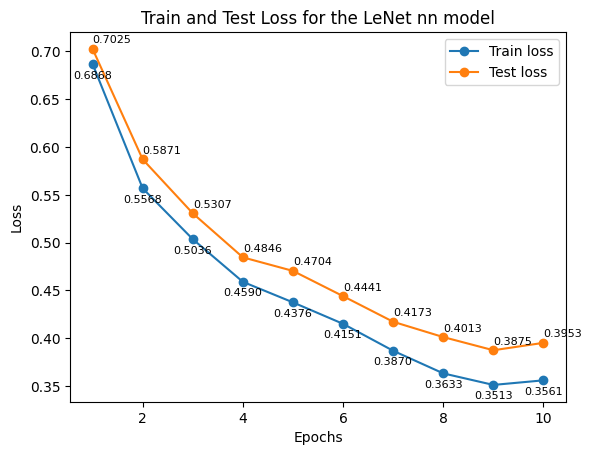

In [14]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_ln5, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.015}), 
                (test_loss_ln5, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': 0.006, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for the LeNet nn model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

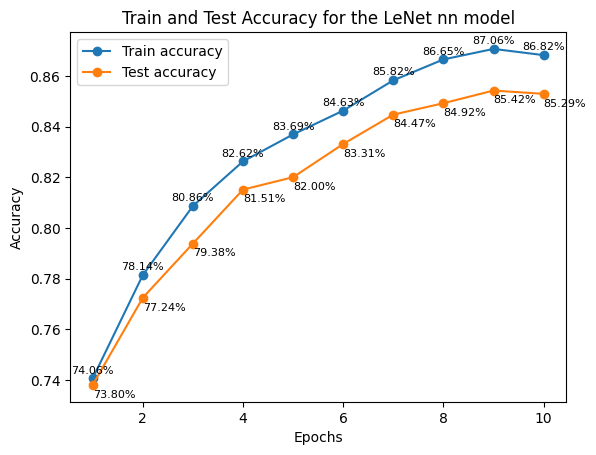

In [15]:
# Defining data and plot params
accuracyDataList = [(train_accuracy_ln5, {'label': 'Train accuracy', 'displayOffset': 0.002,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_ln5, {'label': 'Test accuracy', 'displayOffset': -0.005,
                                 'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'})]
plotTitle = 'Train and Test Accuracy for the LeNet nn model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

### Observations
The results from training and testing the LeNet5 model yields loss and accuracy curves that are gradual than spiky and eratic. It signifies that the model is able to constantly learn at a slow but steady pace while not overshooting its updating of model weights among epochs. However, there is a slight trail off at the very last epoch (I probably should have run it for more epochs but it was just taking too long :( ).

In terms of specifics,
- There are lesser (61,706) total weights here when compared to the previous model which had 94,160 total weights. The test accuracy score of LeNet5 is comparable to that of the vanila model with it having a 2% dip in accuracy.
- The performance in terms of an approximate eye test (should have timed both execution loops :( ) seemed similar.
- There is lesser of an overfitting problem for LeNet5 when comparing the plots. While the previous model had instances that clearly showed overfitting behaviour, it is not apparent here. Maybe slightly between epochs 4 and 5, but that is very slight.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [16]:
##############################
# Your code below

# Define modern LeNet5 model
class ModernLeNet5(nn.Module):
    def __init__(self):
        super(ModernLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

modernLeNet5 = ModernLeNet5().to(device=device)
print(modernLeNet5)
summary(modelLeNet5, (1, 28, 28))

ModernLeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24

In [17]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modernLeNet5.parameters(), lr=1e-3)

epochs = 10
train_loss_mln5, train_accuracy_mln5, test_loss_mln5, test_accuracy_mln5 = train_loop(train_dataloader, test_dataloader, modernLeNet5, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.305827  [   64/60000]
loss: 0.782733  [ 6464/60000]
loss: 0.783996  [12864/60000]
loss: 0.516517  [19264/60000]
loss: 0.533657  [25664/60000]
loss: 0.579616  [32064/60000]
loss: 0.494287  [38464/60000]
loss: 0.354017  [44864/60000]
loss: 0.455302  [51264/60000]
loss: 0.588173  [57664/60000]
Train Error: 
 Accuracy: 83.4%, Avg loss: 0.437353 

Test Error: 
 Accuracy: 82.9%, Avg loss: 0.459127 

Epoch 2:

loss: 0.474979  [   64/60000]
loss: 0.290955  [ 6464/60000]
loss: 0.531888  [12864/60000]
loss: 0.254906  [19264/60000]
loss: 0.562676  [25664/60000]
loss: 0.459014  [32064/60000]
loss: 0.631535  [38464/60000]
loss: 0.445078  [44864/60000]
loss: 0.435281  [51264/60000]
loss: 0.340550  [57664/60000]
Train Error: 
 Accuracy: 87.9%, Avg loss: 0.328589 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.358075 

Epoch 3:

loss: 0.386217  [   64/60000]
loss: 0.356607  [ 6464/60000]
loss: 0.323595  [12864/60000]
loss: 0.308235  [19264/60000]
loss: 0.401014  [25664/60000]
loss: 0.36

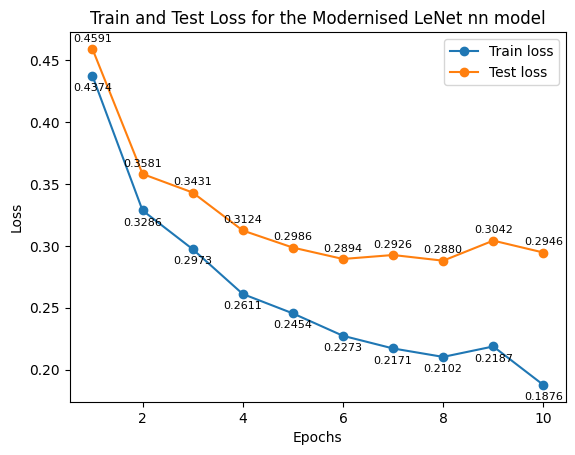

In [155]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_mln5, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.012}), 
                (test_loss_mln5, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': 0.006})]
plotTitle = 'Train and Test Loss for the Modernised LeNet nn model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

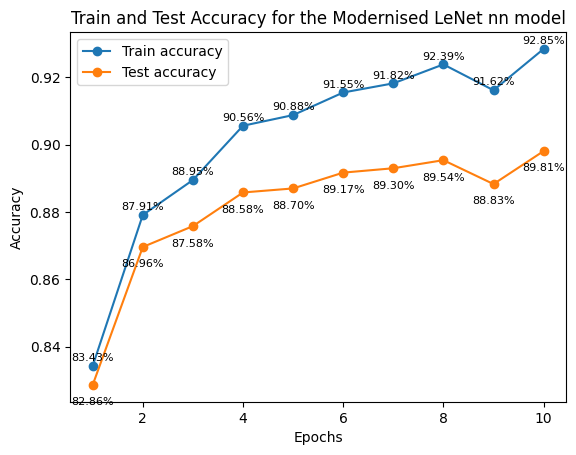

In [148]:
# Defining data and plot params
epochRange = range(1, 11)
accuracyDataList = [(train_accuracy_mln5, {'label': 'Train accuracy', 'displayOffset': 0.0015,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_mln5, {'label': 'Test accuracy', 'displayOffset': -0.006,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for the Modernised LeNet nn model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

To mordernise LeNet5, I made the following changes to the architecture:  
1. Changed the activation function from the sigmoid function to the ReLU function.
2. Changed the pooling from average pooling to max pooling. Max pooling has the behaviour of taking the most prominent feature from its pooling grid which prioritises more recognisable features when compared with average pooling. Hence this is more preferred when it comes to vision algorithms.

#### General observations:
There is a noticable increase in accuracy score compared to both the above nn implementations. Best test accuracy achieved is 89.81%. This also overshot its learning a bit in epoch #9 like our first 100-100-50 vanila model, but the error was less pronounced. There doesn not seem to be any visible signs of overfitting here as opposed to the previous models. 

---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

### Attempt 1
For the first attempt at an nn architecture, I Bing chatted/Googled about and saw an interesting observation in an article (I lost the article link, but I think it was a Machine Learning Mastery post) that many layers in CNNs have their output channels set to powers of 2. Hence, I wanted to give this a go with two convolutional layers having output channels of 32 and 64. As suggested, I performed maxpool only after the last convolutional layer. Also, for this part alone, I ran the model training loops for 20 epochs since I wanted to try and push that 93% accuracy mark. 

In [20]:
# Architecture - Take 1
class ArbitraryNet(nn.Module):
    def __init__(self):
        super(ArbitraryNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

arbitraryNet = ArbitraryNet().to(device=device)
print(arbitraryNet)
summary(arbitraryNet, (1, 28, 28))

ArbitraryNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Linear-4                  [-1, 100]       1,254,500
            Linear-5                   [-1, 10]           1,010
Total params: 1,274,326
Trainable params: 1,274,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/b

In [21]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(arbitraryNet.parameters(), lr=1e-3)

# Running for 20 epochs now than just 10
epochs = 20
train_loss1, train_accuracy1, test_loss1, test_accuracy1 = train_loop(train_dataloader, test_dataloader, arbitraryNet, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.302413  [   64/60000]
loss: 1.595266  [ 6464/60000]
loss: 1.669557  [12864/60000]
loss: 1.673311  [19264/60000]
loss: 1.561951  [25664/60000]
loss: 1.539554  [32064/60000]
loss: 1.590595  [38464/60000]
loss: 1.601310  [44864/60000]
loss: 1.603095  [51264/60000]
loss: 1.638555  [57664/60000]
Train Error: 
 Accuracy: 86.3%, Avg loss: 1.597690 

Test Error: 
 Accuracy: 85.2%, Avg loss: 1.609125 

Epoch 2:

loss: 1.655668  [   64/60000]
loss: 1.592188  [ 6464/60000]
loss: 1.612195  [12864/60000]
loss: 1.630647  [19264/60000]
loss: 1.665473  [25664/60000]
loss: 1.620777  [32064/60000]
loss: 1.557456  [38464/60000]
loss: 1.626661  [44864/60000]
loss: 1.520125  [51264/60000]
loss: 1.551694  [57664/60000]
Train Error: 
 Accuracy: 89.9%, Avg loss: 1.562241 

Test Error: 
 Accuracy: 88.4%, Avg loss: 1.577357 

Epoch 3:

loss: 1.559535  [   64/60000]
loss: 1.616049  [ 6464/60000]
loss: 1.558936  [12864/60000]
loss: 1.527893  [19264/60000]
loss: 1.558790  [25664/60000]
loss: 1.57

### Results

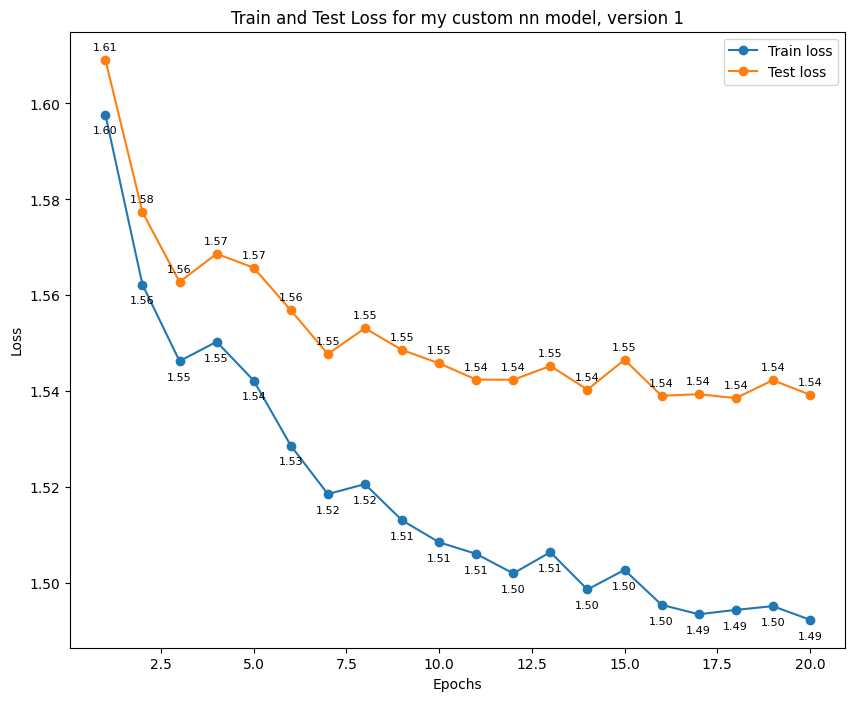

In [142]:
epochRange = range(1, 21)
# Defining data and plot params
lossDataList = [(train_loss1, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.004}), 
                (test_loss1, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.002})]
plotTitle = 'Train and Test Loss for my custom nn model, version 1'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 8))

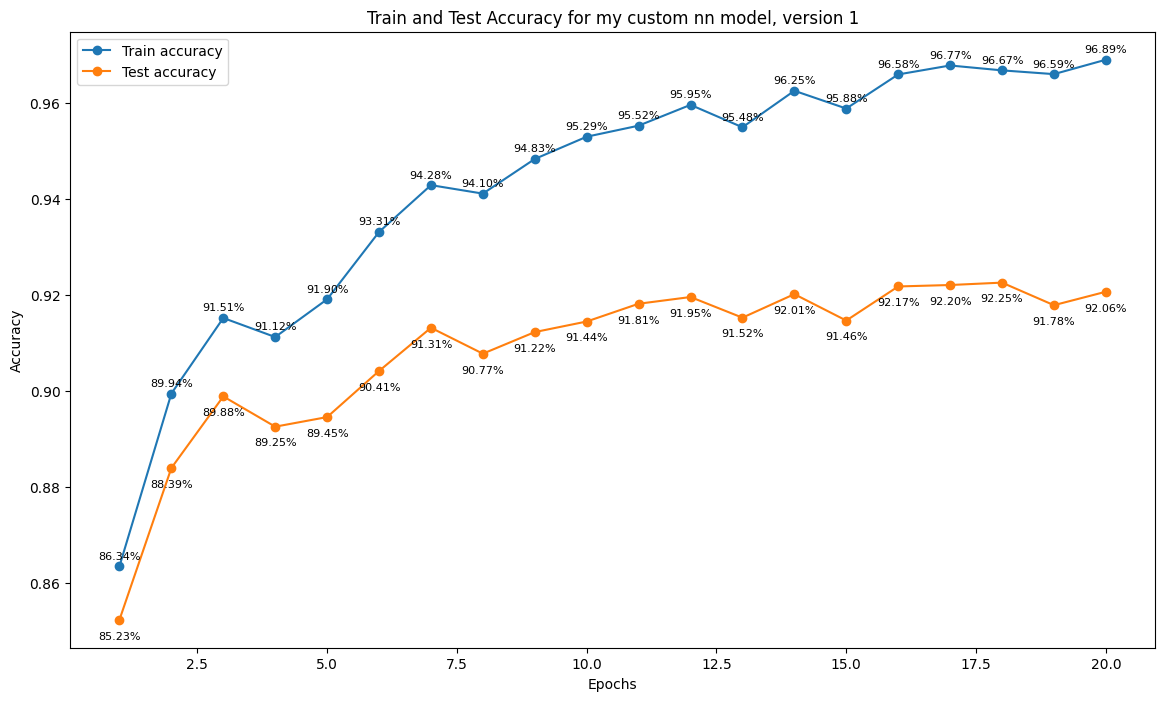

In [138]:
# Defining data and plot params
accuracyDataList = [(train_accuracy1, {'label': 'Train accuracy', 'displayOffset': 0.0015,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy1, {'label': 'Test accuracy', 'displayOffset': -0.004,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for my custom nn model, version 1'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(14, 8))

### Observation
Already, this seemingly simpler model with lesser layers than LeNet has managed to crack the 92% test accuracy mark. Less is more :) ? However, the curves are erratic. Maybe running with a much slower rate of learning might help, but might need more epochs. So, I decided against lowering the learning rate (these took a long time). Also, overfitting is still a problem which is evident especially towards the end.

### Attempt two
Adding batch normalisation layers

In [24]:
# Architecture - take 2
class ArbitraryNet2(nn.Module):
    def __init__(self):
        super(ArbitraryNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

arbitraryNet2 = ArbitraryNet2().to(device=device)
print(arbitraryNet2)
summary(arbitraryNet2, (1, 28, 28))

ArbitraryNet2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 28, 28]          18,496
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]          

In [25]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(arbitraryNet2.parameters(), lr=1e-3)

epochs = 20
train_loss2, train_accuracy2, test_loss2, test_accuracy2 = train_loop(train_dataloader, test_dataloader, arbitraryNet2, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.302044  [   64/60000]
loss: 2.021895  [ 6464/60000]
loss: 1.903375  [12864/60000]
loss: 2.034803  [19264/60000]
loss: 1.901865  [25664/60000]
loss: 1.898324  [32064/60000]
loss: 1.824015  [38464/60000]
loss: 1.987449  [44864/60000]
loss: 1.918702  [51264/60000]
loss: 1.865405  [57664/60000]
Train Error: 
 Accuracy: 58.7%, Avg loss: 1.872613 

Test Error: 
 Accuracy: 57.8%, Avg loss: 1.880937 

Epoch 2:

loss: 1.825873  [   64/60000]
loss: 1.749622  [ 6464/60000]
loss: 1.768713  [12864/60000]
loss: 1.709861  [19264/60000]
loss: 1.851746  [25664/60000]
loss: 1.822876  [32064/60000]
loss: 1.702741  [38464/60000]
loss: 1.820319  [44864/60000]
loss: 1.719528  [51264/60000]
loss: 1.701947  [57664/60000]
Train Error: 
 Accuracy: 71.7%, Avg loss: 1.743687 

Test Error: 
 Accuracy: 70.9%, Avg loss: 1.752018 

Epoch 3:

loss: 1.747187  [   64/60000]
loss: 1.759580  [ 6464/60000]
loss: 1.739874  [12864/60000]
loss: 1.670930  [19264/60000]
loss: 1.693010  [25664/60000]
loss: 1.69

### Results

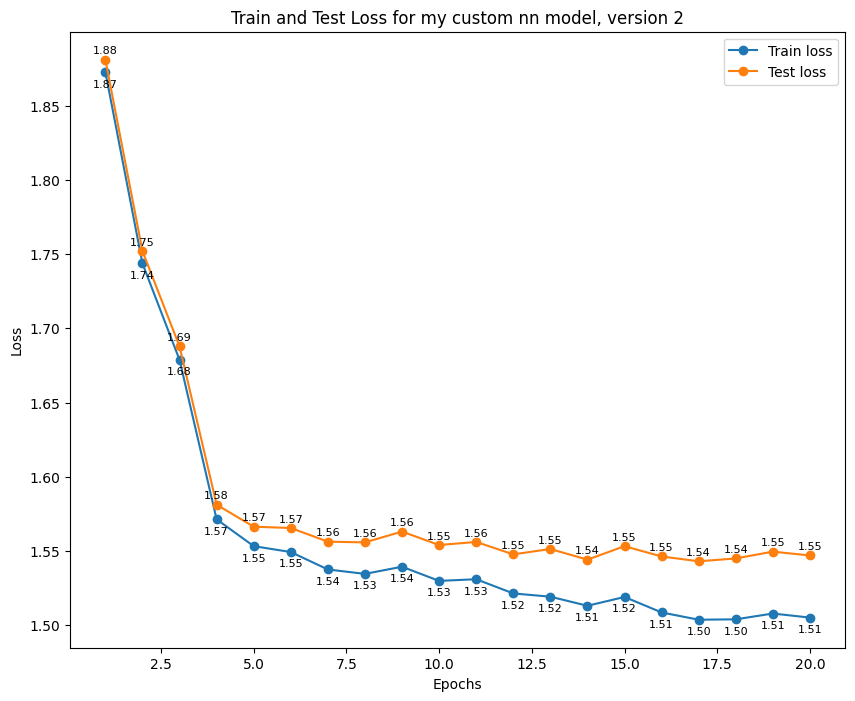

In [134]:
epochRange = range(1, 21)
# Defining data and plot params
lossDataList = [(train_loss2, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.01}), 
                (test_loss2, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.004})]
plotTitle = 'Train and Test Loss for my custom nn model, version 2'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 8))

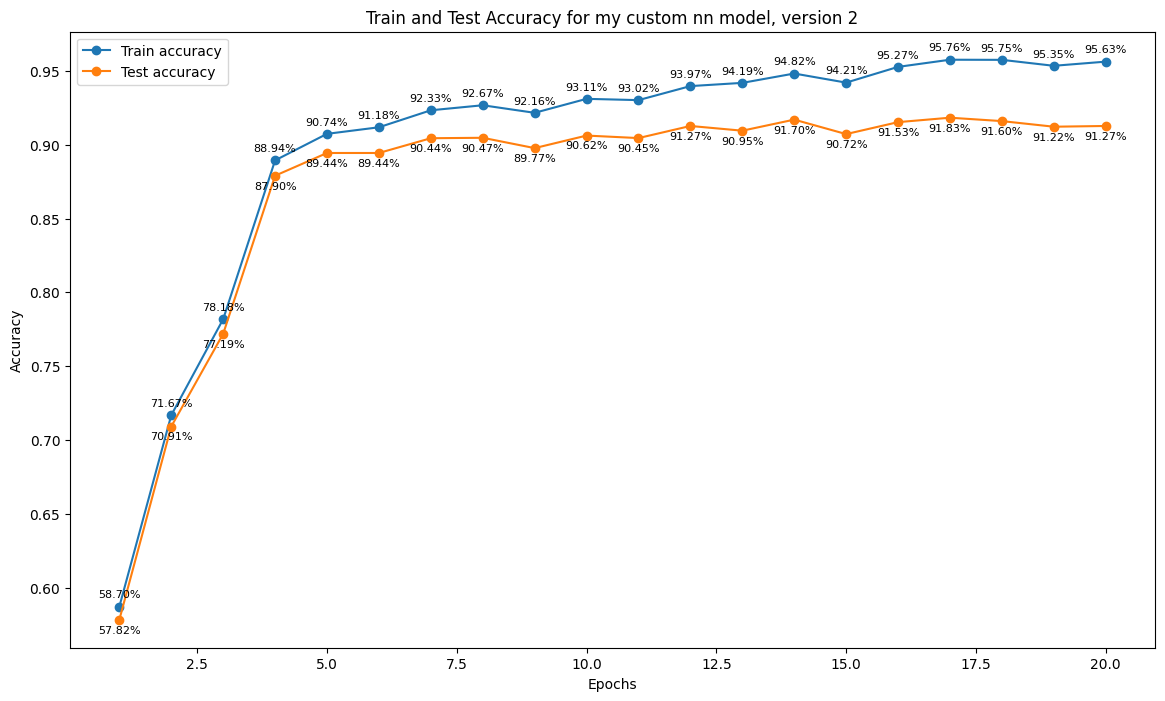

In [127]:
# Defining data and plot params
epochRange = range(1, 21)
accuracyDataList = [(train_accuracy2, {'label': 'Train accuracy', 'displayOffset': 0.006,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy2, {'label': 'Test accuracy', 'displayOffset': -0.009,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for my custom nn model, version 2'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(14, 8))

### Observation:
Interestingly, this has resulted in a slightly lower accuracy score. But, the model seems to be learning a bit more smoothly and overfitting is noticably lesser comparted to attempt #1.

### Attempt three
Adding another fully connected layer and a convolutional layer

In [28]:
# Architecture - take 2
class ArbitraryNet3(nn.Module):
    def __init__(self):
        super(ArbitraryNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

arbitraryNet3 = ArbitraryNet3().to(device=device)
print(arbitraryNet3)
summary(arbitraryNet3, (1, 28, 28))

ArbitraryNet3(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2 

In [29]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(arbitraryNet3.parameters(), lr=1e-3)

epochs = 20
train_loss3, train_accuracy3, test_loss3, test_accuracy3 = train_loop(train_dataloader, test_dataloader, arbitraryNet3, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.304786  [   64/60000]
loss: 1.830272  [ 6464/60000]
loss: 1.708716  [12864/60000]
loss: 1.640303  [19264/60000]
loss: 1.644803  [25664/60000]
loss: 1.633019  [32064/60000]
loss: 1.666909  [38464/60000]
loss: 1.586088  [44864/60000]
loss: 1.694376  [51264/60000]
loss: 1.732999  [57664/60000]
Train Error: 
 Accuracy: 76.5%, Avg loss: 1.695444 

Test Error: 
 Accuracy: 75.6%, Avg loss: 1.705058 

Epoch 2:

loss: 1.648860  [   64/60000]
loss: 1.634313  [ 6464/60000]
loss: 1.643085  [12864/60000]
loss: 1.726426  [19264/60000]
loss: 1.664135  [25664/60000]
loss: 1.633067  [32064/60000]
loss: 1.619909  [38464/60000]
loss: 1.718172  [44864/60000]
loss: 1.664262  [51264/60000]
loss: 1.730895  [57664/60000]
Train Error: 
 Accuracy: 80.5%, Avg loss: 1.655899 

Test Error: 
 Accuracy: 79.8%, Avg loss: 1.662494 

Epoch 3:

loss: 1.649010  [   64/60000]
loss: 1.771377  [ 6464/60000]
loss: 1.683912  [12864/60000]
loss: 1.648011  [19264/60000]
loss: 1.709308  [25664/60000]
loss: 1.64

### Results

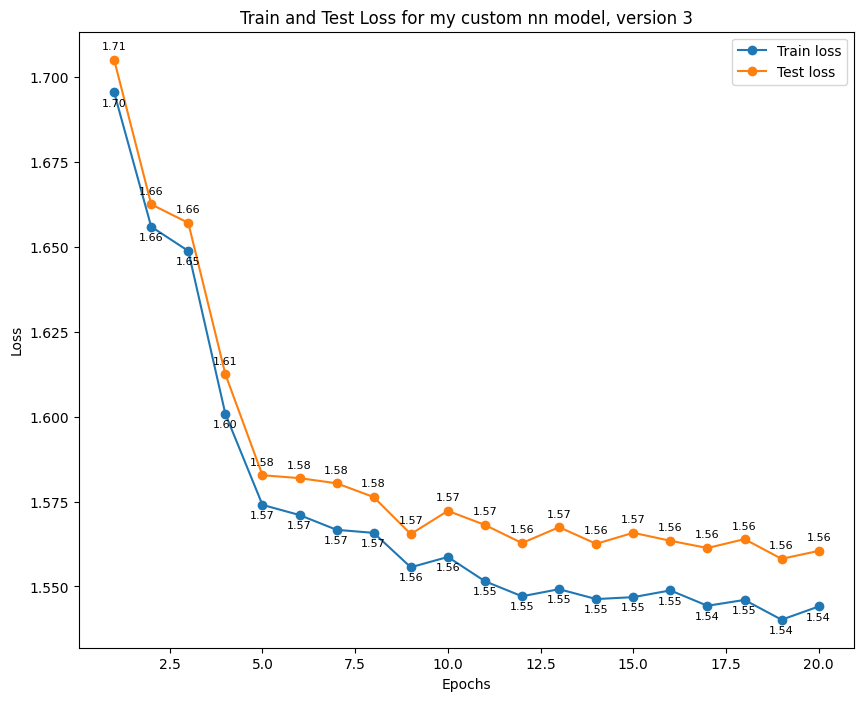

In [158]:
epochRange = range(1, 21)
# Defining data and plot params
lossDataList = [(train_loss3, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.004}), 
                (test_loss3, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.003})]
plotTitle = 'Train and Test Loss for my custom nn model, version 3'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 8))

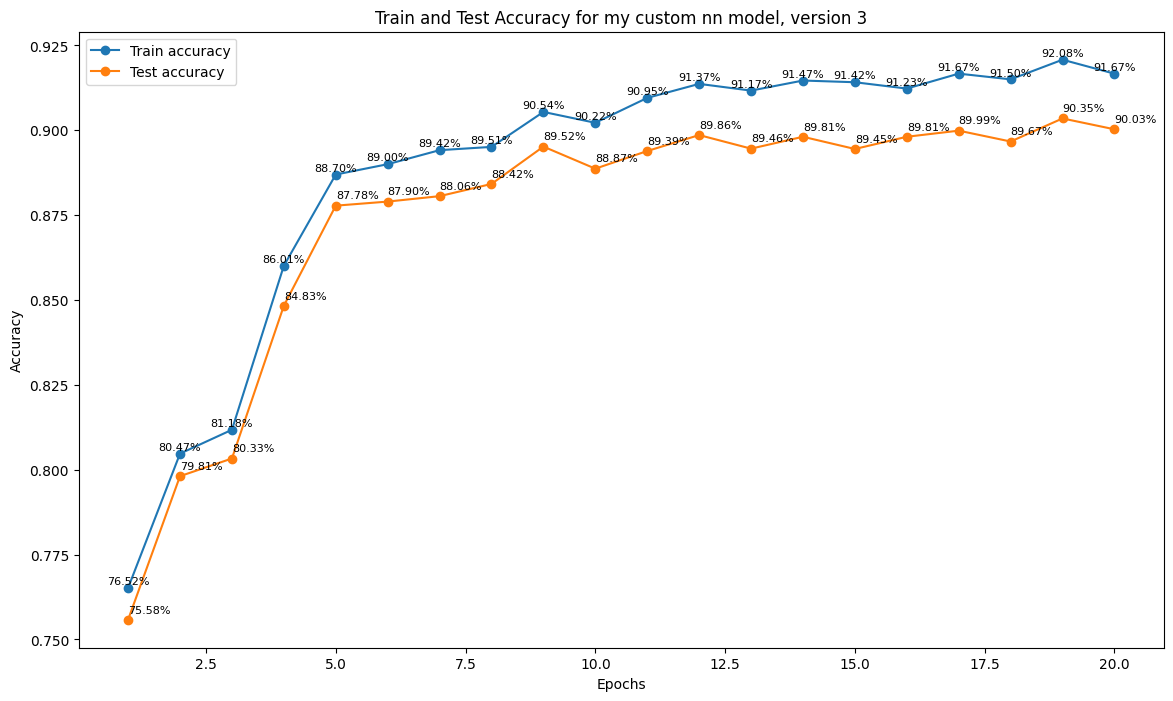

In [31]:
# Defining data and plot params
accuracyDataList = [(train_accuracy3, {'label': 'Train accuracy', 'displayOffset': 0.001,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy3, {'label': 'Test accuracy', 'displayOffset': 0.002,
                                 'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'})]
plotTitle = 'Train and Test Accuracy for my custom nn model, version 3'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(14, 8))

### Observations:
The curves are less smoother and there is more back and forth

### Attempt four
Removing the third convolutional layer

In [32]:
# Architecture - take 4
class ArbitraryNet4(nn.Module):
    def __init__(self):
        super(ArbitraryNet4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

arbitraryNet4 = ArbitraryNet4().to(device=device)
print(arbitraryNet4)
summary(arbitraryNet4, (1, 28, 28))

ArbitraryNet4(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 64, 28, 28]          18,496
       BatchNorm2d-4           [-1, 64, 28, 28]             1

In [33]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(arbitraryNet4.parameters(), lr=1e-3)

epochs = 20
train_loss4, train_accuracy4, test_loss4, test_accuracy4 = train_loop(train_dataloader, test_dataloader, arbitraryNet4, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.300395  [   64/60000]
loss: 1.847174  [ 6464/60000]
loss: 1.814395  [12864/60000]
loss: 1.776112  [19264/60000]
loss: 1.727850  [25664/60000]
loss: 1.728056  [32064/60000]
loss: 1.684741  [38464/60000]
loss: 1.662241  [44864/60000]
loss: 1.660941  [51264/60000]
loss: 1.662401  [57664/60000]
Train Error: 
 Accuracy: 80.3%, Avg loss: 1.657288 

Test Error: 
 Accuracy: 79.5%, Avg loss: 1.666875 

Epoch 2:

loss: 1.562060  [   64/60000]
loss: 1.633271  [ 6464/60000]
loss: 1.761639  [12864/60000]
loss: 1.673441  [19264/60000]
loss: 1.605087  [25664/60000]
loss: 1.651656  [32064/60000]
loss: 1.578226  [38464/60000]
loss: 1.617729  [44864/60000]
loss: 1.696499  [51264/60000]
loss: 1.707984  [57664/60000]
Train Error: 
 Accuracy: 81.5%, Avg loss: 1.646163 

Test Error: 
 Accuracy: 80.7%, Avg loss: 1.653441 

Epoch 3:

loss: 1.657386  [   64/60000]
loss: 1.733757  [ 6464/60000]
loss: 1.647604  [12864/60000]
loss: 1.650784  [19264/60000]
loss: 1.610971  [25664/60000]
loss: 1.67

### Results

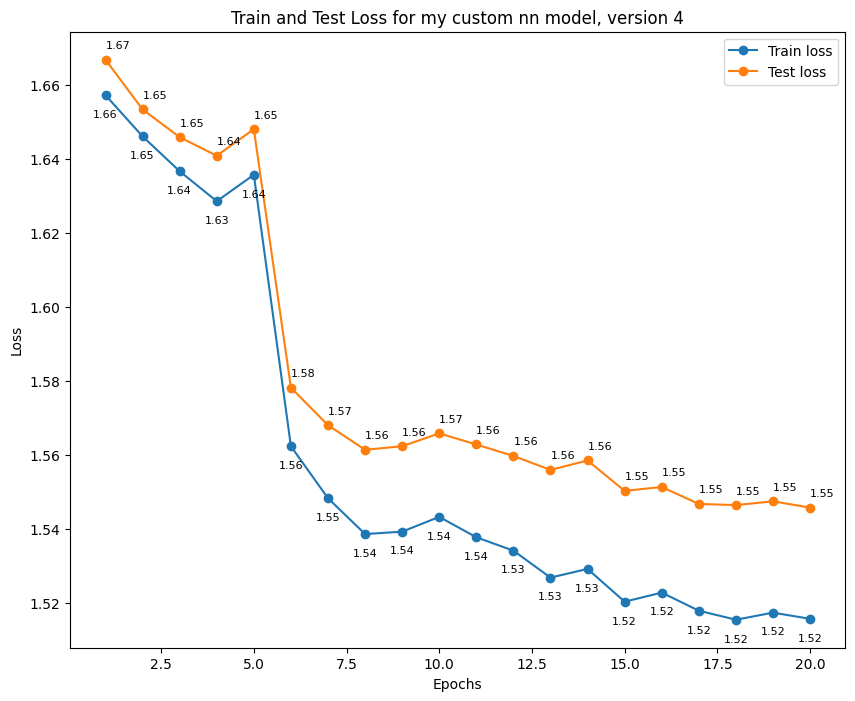

In [160]:
epochRange = range(1, 21)
# Defining data and plot params
lossDataList = [(train_loss4, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.006}), 
                (test_loss4, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.003, 'ha': 'left'})]
plotTitle = 'Train and Test Loss for my custom nn model, version 4'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 8))

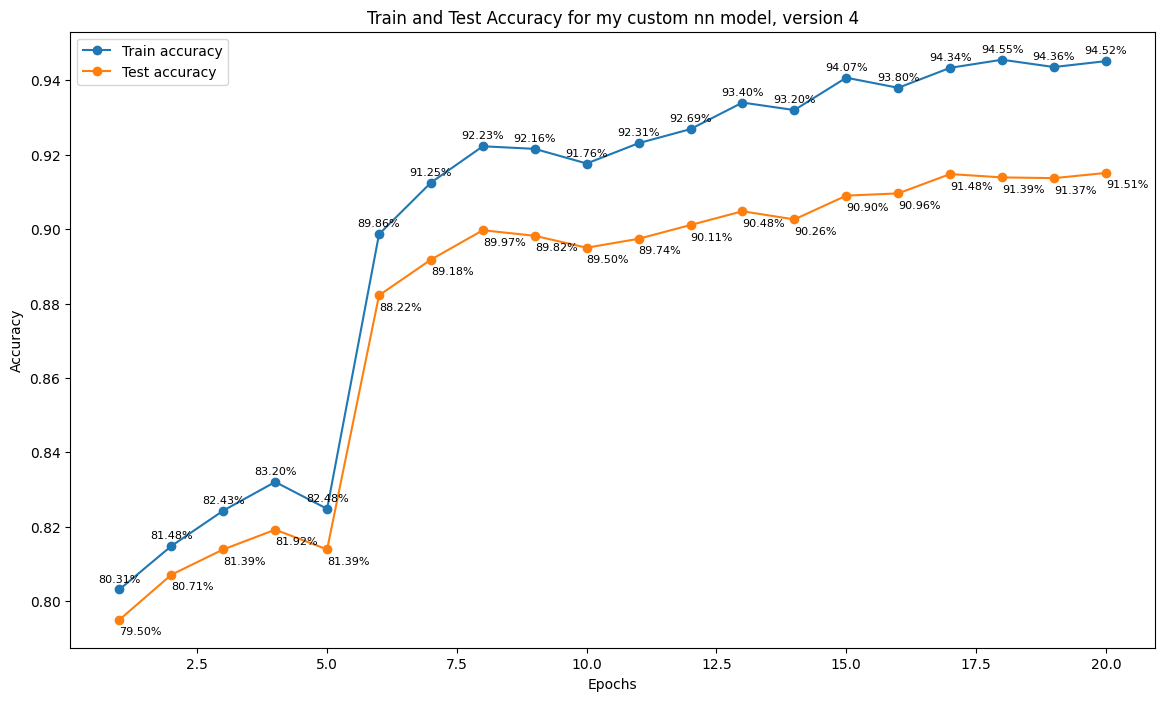

In [35]:
# Defining data and plot params
accuracyDataList = [(train_accuracy4, {'label': 'Train accuracy', 'displayOffset': 0.002,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy4, {'label': 'Test accuracy', 'displayOffset': -0.004,
                                 'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'})]
plotTitle = 'Train and Test Accuracy for my custom nn model, version 4'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(14, 8))

### Take five
Resetting the architecture to attempt #2 in terms of layers, but using a padding of 2 for the first convolutional layer.

In [58]:
# Architecture - take 5
class ArbitraryNet5(nn.Module):
    def __init__(self):
        super(ArbitraryNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 15 * 15, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

arbitraryNet5 = ArbitraryNet5().to(device=device)
print(arbitraryNet5)
summary(arbitraryNet5, (1, 28, 28))

ArbitraryNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 64, 30, 30]          18,496
       BatchNorm2d-4           [-1, 64, 30, 30]             128
         MaxPool2d-5           [-1, 64, 15, 15]          

In [59]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(arbitraryNet5.parameters(), lr=1e-3)

epochs = 20
train_loss5, train_accuracy5, test_loss5, test_accuracy5 = train_loop(train_dataloader, test_dataloader, arbitraryNet5, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.305227  [   64/60000]
loss: 1.774637  [ 6464/60000]
loss: 1.771706  [12864/60000]
loss: 1.759505  [19264/60000]
loss: 1.831464  [25664/60000]
loss: 1.610657  [32064/60000]
loss: 1.761964  [38464/60000]
loss: 1.681763  [44864/60000]
loss: 1.722343  [51264/60000]
loss: 1.648021  [57664/60000]
Train Error: 
 Accuracy: 76.6%, Avg loss: 1.694738 

Test Error: 
 Accuracy: 75.5%, Avg loss: 1.705670 

Epoch 2:

loss: 1.749558  [   64/60000]
loss: 1.761039  [ 6464/60000]
loss: 1.804805  [12864/60000]
loss: 1.659221  [19264/60000]
loss: 1.726348  [25664/60000]
loss: 1.780938  [32064/60000]
loss: 1.655698  [38464/60000]
loss: 1.681699  [44864/60000]
loss: 1.741037  [51264/60000]
loss: 1.744603  [57664/60000]
Train Error: 
 Accuracy: 78.0%, Avg loss: 1.680526 

Test Error: 
 Accuracy: 77.1%, Avg loss: 1.689712 

Epoch 3:

loss: 1.575324  [   64/60000]
loss: 1.660450  [ 6464/60000]
loss: 1.648233  [12864/60000]
loss: 1.549973  [19264/60000]
loss: 1.711296  [25664/60000]
loss: 1.72

### Results

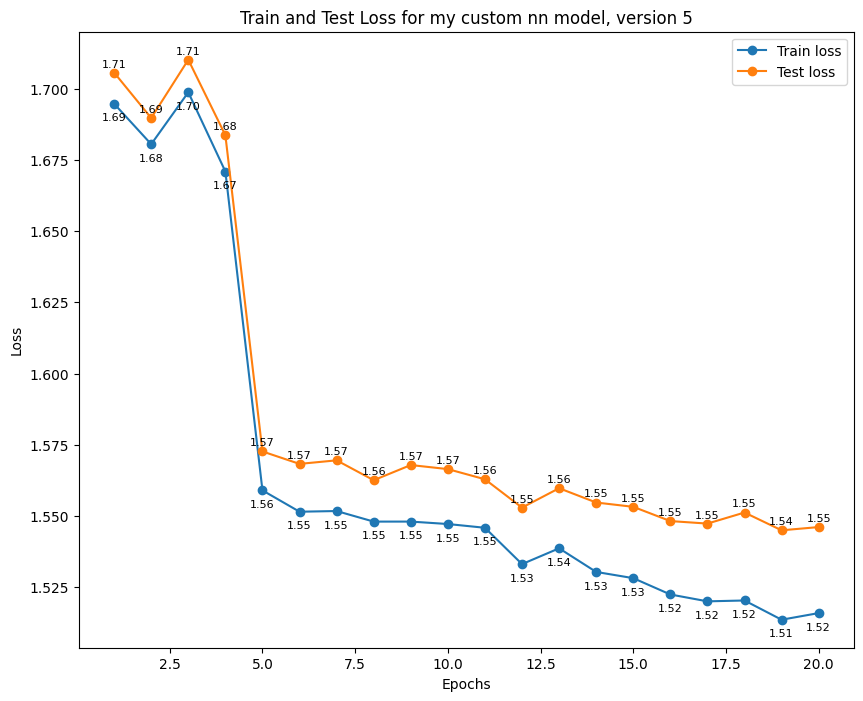

In [166]:
epochRange = range(1, 21)
# Defining data and plot params
lossDataList = [(train_loss5, {'label': 'Train loss', 'decimalPlaces': 2, 'displayOffset': -0.006}), 
                (test_loss5, {'label': 'Test loss', 'decimalPlaces': 2, 'displayOffset': 0.002})]
plotTitle = 'Train and Test Loss for my custom nn model, version 5'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 8))

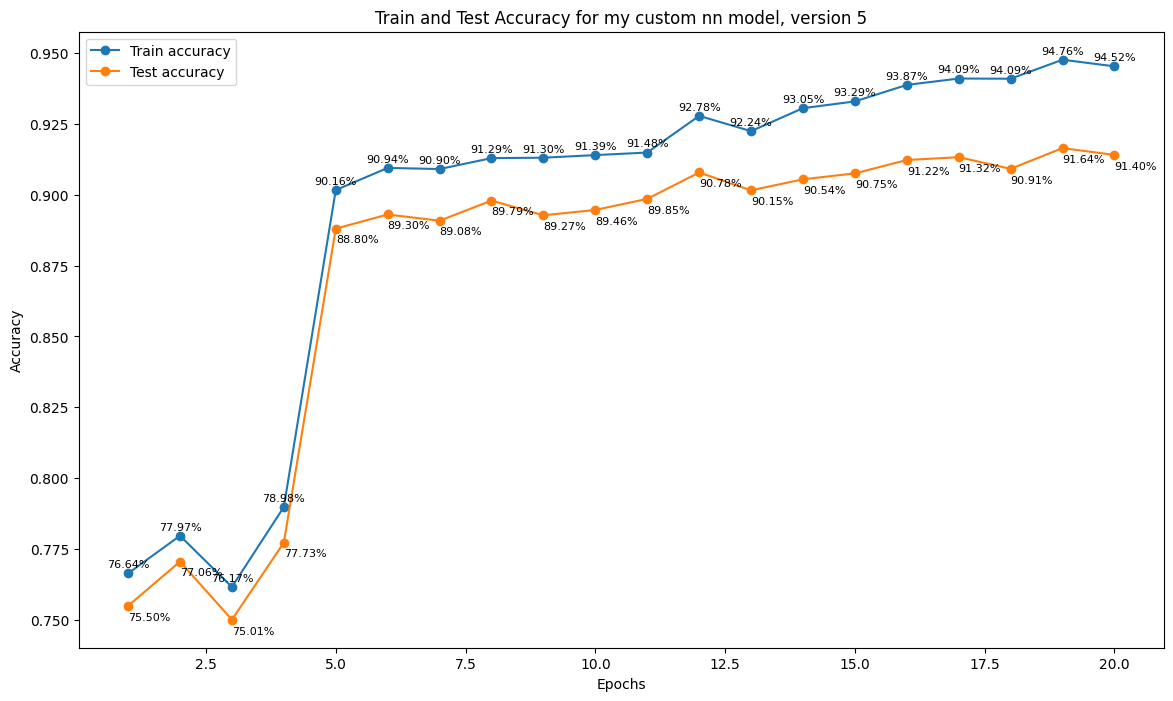

In [161]:
# Defining data and plot params
accuracyDataList = [(train_accuracy5, {'label': 'Train accuracy', 'displayOffset': 0.002,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy5, {'label': 'Test accuracy', 'displayOffset': -0.005,
                                 'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'})]
plotTitle = 'Train and Test Accuracy for my custom nn model, version 5'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(14, 8))

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Overall, the architecture variation #2 seems to have performed best in terms of balance between a good accuracy score and less overfitting.

---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [62]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data_3c = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data_3c = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader_3c = torch.utils.data.DataLoader(training_data_3c, batch_size=batch_size)
test_dataloader_3c = torch.utils.data.DataLoader(test_data_3c, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100%|█████████████████████████| 26421880/26421880 [00:02<00:00, 11145415.56it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 1002330.90it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 8813064.24it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 5731955.67it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

### 1. Reseting ResNet18's pretrained weights

In [83]:
##############################
# Your code below

# Load ResNet18 with random weights
model_resnet18_1 = models.resnet18(weights=None)

# Replace the fully connected layer at the end with your own fully connected layer
model_resnet18_1.fc = nn.Linear(512, 10)
model_resnet18_1 = model_resnet18_1.to(device=device)
epochs = 10

# printing out the model architecture out of curiosity :)
print(model_resnet18_1)
summary(model_resnet18_1, (3, 28, 28))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18_1.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

##############################
# Your code below

# Train the model
train_loss_resnet18_1, train_accuracy_resnet18_1, test_loss_resnet18_1, test_accuracy_resnet18_1 = train_loop(train_dataloader_3c, test_dataloader_3c, model_resnet18_1, loss_fn, optimizer, epochs=epochs)

Epoch 1:

loss: 2.514284  [   64/60000]
loss: 0.547428  [ 6464/60000]
loss: 0.324259  [12864/60000]
loss: 0.536448  [19264/60000]
loss: 0.499960  [25664/60000]
loss: 0.406729  [32064/60000]
loss: 0.287481  [38464/60000]
loss: 0.509442  [44864/60000]
loss: 0.365509  [51264/60000]
loss: 0.338177  [57664/60000]
Train Error: 
 Accuracy: 86.8%, Avg loss: 0.350166 

Test Error: 
 Accuracy: 85.4%, Avg loss: 0.391405 

Epoch 2:

loss: 0.314552  [   64/60000]
loss: 0.361836  [ 6464/60000]
loss: 0.228202  [12864/60000]
loss: 0.374697  [19264/60000]
loss: 0.334212  [25664/60000]
loss: 0.379137  [32064/60000]
loss: 0.238378  [38464/60000]
loss: 0.373408  [44864/60000]
loss: 0.275582  [51264/60000]
loss: 0.287794  [57664/60000]
Train Error: 
 Accuracy: 88.5%, Avg loss: 0.302385 

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.354018 

Epoch 3:

loss: 0.229577  [   64/60000]
loss: 0.295484  [ 6464/60000]
loss: 0.223085  [12864/60000]
loss: 0.276156  [19264/60000]
loss: 0.276211  [25664/60000]
loss: 0.34

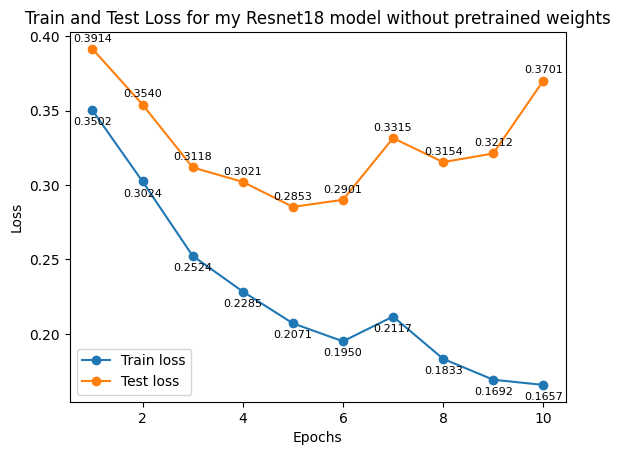

In [90]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_resnet18_1, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.01}), 
                (test_loss_resnet18_1, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': 0.005})]
plotTitle = 'Train and Test Loss for my Resnet18 model without pretrained weights'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

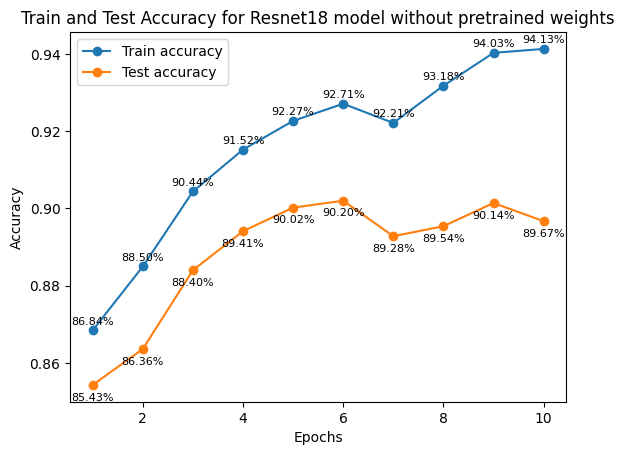

In [95]:
# Defining data and plot params
accuracyDataList = [(train_accuracy_resnet18_1, {'label': 'Train accuracy', 'displayOffset': 0.0015,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_resnet18_1, {'label': 'Test accuracy', 'displayOffset': -0.004,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Resnet18 model without pretrained weights'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### 2. Using ResNet18's pretrained weights

In [104]:
##############################
# Your code below

# Load ResNet18 with default parameters i.e, using pretrained weights
model_resnet18_2 = models.resnet18()

# Replacing the fully connected layer at the end
model_resnet18_2.fc = nn.Linear(512, 10)

model_resnet18_2 = model_resnet18_2.to(device=device)

In [80]:
# Define the loss function and the optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18_2.parameters(), lr=1e-3)

# Training the model with default parameters i.e, pretrained ResNet18 weights
train_loss_resnet18_2, train_accuracy_resnet18_2, test_loss_resnet18_2, test_accuracy_resnet18_2 = train_loop(train_dataloader_3c, test_dataloader_3c, model_resnet18_2, loss_fn, optimizer, epochs=epochs)

Epoch 1:

loss: 2.528830  [   64/60000]
loss: 0.497187  [ 6464/60000]
loss: 0.362860  [12864/60000]
loss: 0.462228  [19264/60000]
loss: 0.629628  [25664/60000]
loss: 0.437219  [32064/60000]
loss: 0.331352  [38464/60000]
loss: 0.457041  [44864/60000]
loss: 0.282537  [51264/60000]
loss: 0.419532  [57664/60000]
Train Error: 
 Accuracy: 86.6%, Avg loss: 0.362557 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.407029 

Epoch 2:

loss: 0.294891  [   64/60000]
loss: 0.317917  [ 6464/60000]
loss: 0.267864  [12864/60000]
loss: 0.308265  [19264/60000]
loss: 0.334140  [25664/60000]
loss: 0.356817  [32064/60000]
loss: 0.205236  [38464/60000]
loss: 0.359729  [44864/60000]
loss: 0.242791  [51264/60000]
loss: 0.326180  [57664/60000]
Train Error: 
 Accuracy: 88.2%, Avg loss: 0.317272 

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.369695 

Epoch 3:

loss: 0.199124  [   64/60000]
loss: 0.215740  [ 6464/60000]
loss: 0.243515  [12864/60000]
loss: 0.262591  [19264/60000]
loss: 0.314073  [25664/60000]
loss: 0.36

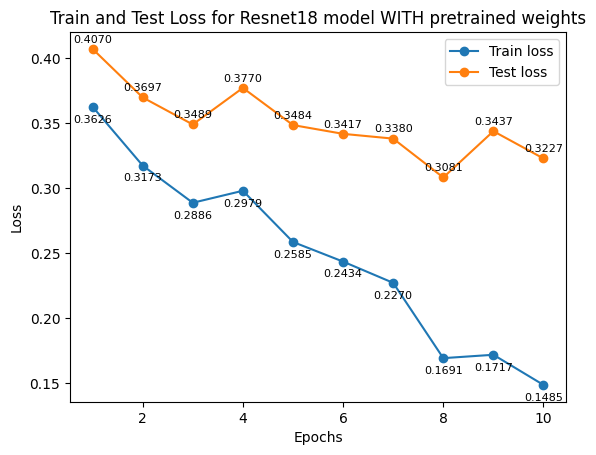

In [98]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_resnet18_2, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.012}), 
                (test_loss_resnet18_2, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': 0.005})]
plotTitle = 'Train and Test Loss for Resnet18 model WITH pretrained weights'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

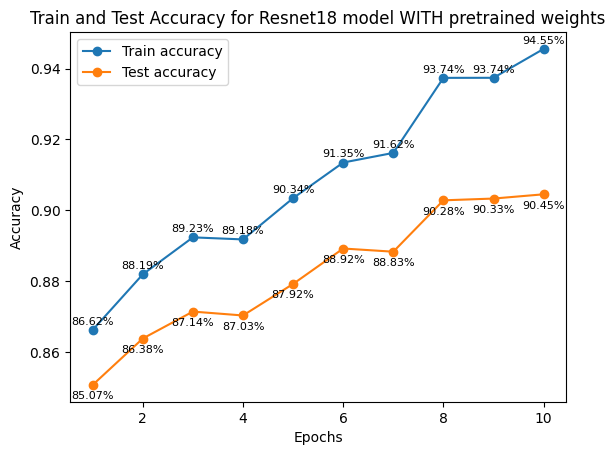

In [101]:
# Defining data and plot params
accuracyDataList = [(train_accuracy_resnet18_2, {'label': 'Train accuracy', 'displayOffset': 0.0015,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_resnet18_2, {'label': 'Test accuracy', 'displayOffset': -0.004,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Resnet18 model WITH pretrained weights'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### 3. Freezing all layers except for the fully connected inference layer

In [109]:
##############################
# Your code below

# Load ResNet18 with default parameters i.e, using pretrained weights
model_resnet18_3 = models.resnet18()

# Freezing all layers
for param in model_resnet18_3.parameters():
    param.requires_grad = False

# Replacing the fully connected layer at the end
model_resnet18_3.fc = nn.Linear(512, 10) # Also, after debugging, apparently newly added layers have requires_grad=True by default.

model_resnet18_3 = model_resnet18_3.to(device=device)

In [110]:
# Define the loss function and the optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18_3.parameters(), lr=1e-3)

# Training the model with default parameters i.e, pretrained ResNet18 weights
train_loss_resnet18_3, train_accuracy_resnet18_3, test_loss_resnet18_3, test_accuracy_resnet18_3 = train_loop(train_dataloader_3c, test_dataloader_3c, model_resnet18_3, loss_fn, optimizer, epochs=epochs)

Epoch 1:

loss: 2.578177  [   64/60000]
loss: 1.100533  [ 6464/60000]
loss: 0.668768  [12864/60000]
loss: 0.995624  [19264/60000]
loss: 0.838449  [25664/60000]
loss: 0.878910  [32064/60000]
loss: 0.836961  [38464/60000]
loss: 0.779513  [44864/60000]
loss: 0.737764  [51264/60000]
loss: 0.802858  [57664/60000]
Train Error: 
 Accuracy: 75.4%, Avg loss: 0.705018 

Test Error: 
 Accuracy: 73.7%, Avg loss: 0.751489 

Epoch 2:

loss: 0.658727  [   64/60000]
loss: 0.801753  [ 6464/60000]
loss: 0.508147  [12864/60000]
loss: 0.867952  [19264/60000]
loss: 0.743809  [25664/60000]
loss: 0.831399  [32064/60000]
loss: 0.739596  [38464/60000]
loss: 0.780098  [44864/60000]
loss: 0.704191  [51264/60000]
loss: 0.738862  [57664/60000]
Train Error: 
 Accuracy: 76.5%, Avg loss: 0.669599 

Test Error: 
 Accuracy: 74.3%, Avg loss: 0.726826 

Epoch 3:

loss: 0.615287  [   64/60000]
loss: 0.765700  [ 6464/60000]
loss: 0.472646  [12864/60000]
loss: 0.839911  [19264/60000]
loss: 0.721088  [25664/60000]
loss: 0.81

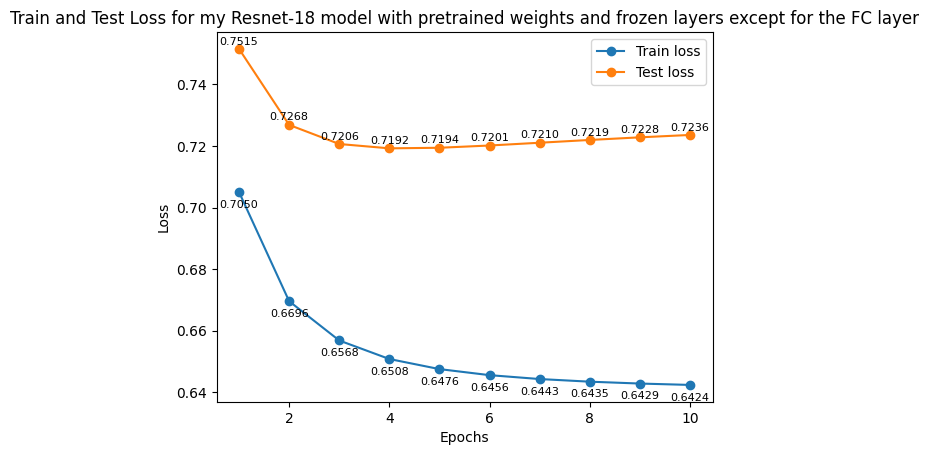

In [118]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss_resnet18_3, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': -0.005}), 
                (test_loss_resnet18_3, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': 0.0015})]
plotTitle = 'Train and Test Loss for my Resnet-18 model with pretrained weights and frozen layers except for the FC layer'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

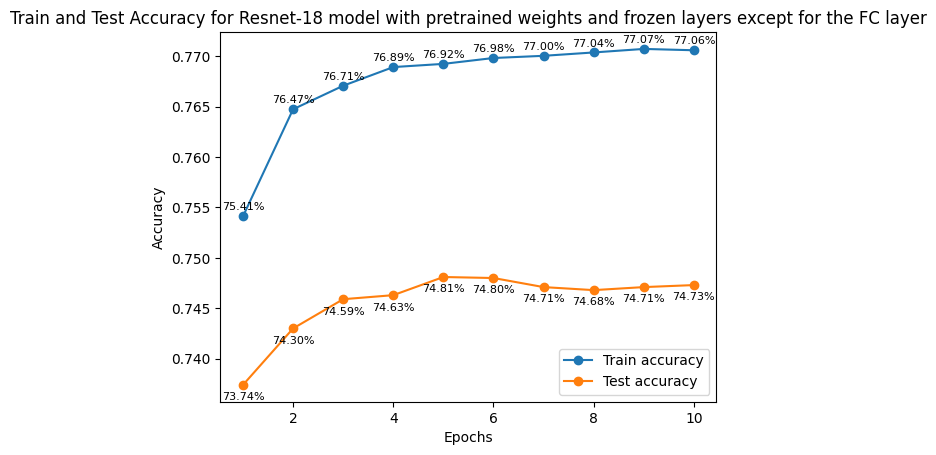

In [122]:
# Defining data and plot params
accuracyDataList = [(train_accuracy_resnet18_3, {'label': 'Train accuracy', 'displayOffset': 0.0006,
                                      'decimalPlaces': 2, 'displayPercent': True}), 
                (test_accuracy_resnet18_3, {'label': 'Test accuracy', 'displayOffset': -0.0015,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Resnet-18 model with pretrained weights and frozen layers except for the FC layer'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

When not using pretrained weights and retraining the whole nn on just the fashion mnist data, the model has overfitted by a lot after hitting an accuracy peak for test data. The sheer number of layers and parameters would surely mean overfitting here with the limited data and variance among the images when dealing with such low resolutions.  
The variation that used the pretrained weights definitely performed better but was not immune to overfitting either. But it was better because the weights learned already contributed a lot in terms of classification capabilities.  
The final variation where only the final fc layer was retrained resulted in a way lower accuracy score. But, this is the first variation that does not show any signs of any overfitting at all.  
Overall, a middle ground between the 2nd and 3rd variations would probably be the way to go as you'd suggested.